# Project 2 - The best feature selection methods
### Hubert Jaczyński, Aleksandra Kłos, Jakub Oganowski

## Introduction
In this project, our goal is to develop a predictive model that is both accurate and cost-effective — meaning it should reliably identify high-energy households based on as few variables as possible. Such dual focus is driven by a business case: detailed data collection is expensive, and the utility provider wants to target support effectively.

## Data

**Training data:**

- 5000 households x 500 anonymized variables (`x_train.txt`)

- Labels indicating high (label 1) vs. acceptable usage (label 0) (`y_train.txt`)


**Test data:**

- 5000 households, same variables (`x_test.txt`)


Our prediction task is to select 1000 households from the test set that are most likely to exceed the usage threshold next month, as the utility company can only offer the energy-saving package to a limited number of clients per month.

# Model evaluation criteria

Model performance is measured by a score (in our case called `net_score`) that rewards accurate identification of high usage households. Nevertheless, it penalizes the number of variables used in order to reflect data costs:

- +10 EUR for each correctly identified household

- -200 EUR for each variable used in the model

Thus, the objective is to maximize this score.


# Methdology

To address the problem, we will focus on data preprocessing and feature selection with an aim to remove as many non-informative/redundant columns as possible at the very beginning. More precisely, we will:

- Calculate basic statistics and compare distributions between training and test sets.

- Remove mismatched columns.

- Calculate variable correlations

- Check for outliers to reduce their impact on model fitting


Our research is highly based on the ideas mentioned in this comprehensive blog: https://neptune.ai/blog/tabular-data-binary-classification-tips-and-tricks-from-5-kaggle-competitions#:~:text=%2A%20Stratified%20KFold%20cross,Time%20Series%20split%20validation

# Library definitions

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp



# Data preprocessing

First of all, let us check some features' statistics in both train and test data. Let us then compare top 10 of them:

In [2]:
x_train = pd.read_csv('/content/x_train.txt', sep=r'\s+', header=None)
y_train = pd.read_csv('/content/y_train.txt', sep=r'\s+', header=None)[0]
x_test  = pd.read_csv('/content/x_test.txt',  sep=r'\s+', header=None)

stats = []
for i in x_train.columns:
    t_mean = x_train[i].mean()
    s_mean = x_test[i].mean()
    t_var = x_train[i].var()
    s_var = x_test[i].var()
    stats.append({
        'feature': i,
        'train_mean': t_mean,
        'test_mean': s_mean,
        'mean_diff': s_mean - t_mean,
        'train_variance': t_var,
        'test_variance': s_var,
        'variance_ratio': (s_var / t_var) if t_var>0 else np.nan,
        'corr_with_target': x_train[i].corr(y_train)})

summary_df = pd.DataFrame(stats).set_index('feature')

print(summary_df.head(10))


         train_mean  test_mean  mean_diff  train_variance  test_variance  \
feature                                                                    
0         15.560411  15.507078  -0.053333       18.730704      17.260227   
1         12.650449  12.655507   0.005058       14.317654      13.704232   
2         27.750084  27.736016  -0.014067       48.258792      44.019127   
3         18.796808  18.825133   0.028325       24.323544      22.632589   
4         19.071302  18.995343  -0.075959       27.471500      25.135808   
5         11.820110  11.769083  -0.051027       13.312292      12.482966   
6         19.365360  19.355964  -0.009395       28.260874      25.857634   
7         15.602632  15.517396  -0.085235       19.669401      18.001512   
8         14.163618  14.233636   0.070018       19.810112      19.051235   
9         15.989661  16.041487   0.051826       22.978933      22.298445   

         variance_ratio  corr_with_target  
feature                                    

The above results suggest us the following:

- Train and test feature means are nearly identical for the top 10 features, with differences all less than 0.1. This means that training and test datasets are well-matched and there is no significant shift or anomaly in the feature distributions.

- Feature variances are also very similar between train and test sets, meaning that the spread and variability of each feature is consistent across both datasets.

- Lastly, the correlation of each feature with the target variable in the training set ranges from about 0.28 to 0.37. The results indicate that these features are to some degree informative for predicting the target, but none is extremely dominant.

In this part, we will look at distribution mismatches and test using Komogorov-Smirnov test (ref: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm). Moreover, we will look at outliers and cap them to 1st and 99th percentiles and display mismatches:

In [33]:
q_low = x_train.quantile(0.01)
q_high = x_train.quantile(0.99)

stats = []

for col in x_train.columns:
    ks_stat, ks_p = ks_2samp(x_train[col], x_test[col])
    train_outliers = ((x_train[col] < q_low[col]) | (x_train[col] > q_high[col])).sum()
    test_outliers = ((x_test[col]  < q_low[col]) | (x_test[col]  > q_high[col])).sum()
    stats.append({
        'feature': col,
        'ks_stat': ks_stat,
        'ks_pvalue': ks_p,
        'train_outliers': train_outliers,
        'test_outliers': test_outliers,
        'train_q01': q_low[col],
        'train_q99': q_high[col],
        'train_min': x_train[col].min(),
        'train_max': x_train[col].max(),
        'test_min': x_test[col].min(),
        'test_max': x_test[col].max(),})

stats_df = pd.DataFrame(stats).set_index('feature')

print("KS statistics for top 10 ks_stat features:")
print(stats_df.sort_values('ks_stat', ascending=False).head(10))

x_train_capped = x_train.clip(lower=q_low, upper=q_high, axis=1)
x_test_capped = x_test.clip( lower=q_low, upper=q_high, axis=1)

ks_after = []

for col in x_train.columns:
    ks2, p2 = ks_2samp(x_train_capped[col], x_test_capped[col])
    ks_after.append(ks2)
stats_df['ks_after_capping'] = ks_after

print("\nKS statistics for top 10 ks_stat features: after capping:")
top10 = stats_df.sort_values('ks_stat', ascending=False).head(10)
print(top10[['ks_stat','ks_after_capping']])

KS statistics for top 10 ks_stat features:
         ks_stat  ks_pvalue  train_outliers  test_outliers  train_q01  \
feature                                                                 
428       0.0426   0.000229             100            112   2.665452   
107       0.0368   0.002291             100             97  -2.315544   
130       0.0368   0.002291             100            105  -2.249431   
135       0.0354   0.003798             100            110  -2.354010   
394       0.0340   0.006174             100            156   0.012440   
303       0.0338   0.006607             100             76   0.008643   
296       0.0336   0.007068             100             92   0.022230   
252       0.0324   0.010504             100            108   0.025570   
34        0.0314   0.014451             100             99  -2.257608   
266       0.0308   0.017417             100            144   0.030595   

         train_q99  train_min  train_max  test_min   test_max  
feature         

We can interpret the results as follows:

- The Komogorov-Smirnov test shows that the top 10 features with the largest distribution differences between `train` and `test` have Komogorov-Smirnov statistics below 0.05. This suggests the overall shape of these distributions is quite similar, but some differences are statistically significant due to large sample sizes.

- Restricting outliers to the 1st and 99th percentiles has had almost no effect on the Komogorov-Smirnov statistic. This mean the misfit of the distributions between the control and test groups is not due to a small number of outliers but rather to small differences across most of the distributions.

- Finally, although the p-values of the Komogorov-Smirnov test indicate plausible differences, the absolute magnitude of the differences is small as all Komogorov-Smirnov statistics are less than 0.05. Thus, the impact on model generalizability is rather minimal.

Now, we will recalculate Komogorov-Smirnov test, use QuantileTransformer to cap the data. Moreover, we will utilize Adversarial Validation using Random Forest to distinguish between test and train, as well as we will drop some of the features that mismatch:

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score


q_low, q_high = x_train.quantile(0.01), x_train.quantile(0.99)

stats = []

for col in x_train.columns:
    ks_stat, _ = ks_2samp(x_train[col], x_test[col])
    test_out = ((x_test[col] < q_low[col]) | (x_test[col] > q_high[col])).sum()
    stats.append({'feature': col, 'ks_stat': ks_stat, 'test_outliers': test_out})
stats_df = pd.DataFrame(stats).set_index('feature')

ks_thresh = 0.035
outlier_thresh = 120
flagged = stats_df[
    (stats_df['ks_stat'] >= ks_thresh) |
    (stats_df['test_outliers'] > outlier_thresh)].index.tolist()

print(f"Flagged features (KS >= {ks_thresh} or test_outliers > {outlier_thresh}):\n{flagged}\n")

qt = QuantileTransformer(output_distribution='uniform', random_state=0)
combined = pd.concat([x_train[flagged], x_test[flagged]], axis=0)
qt.fit(combined)

x_train_qt = x_train.copy()
x_test_qt = x_test.copy()
x_train_qt[flagged] = qt.transform(x_train[flagged])
x_test_qt[flagged] = qt.transform(x_test[flagged])

X_adv = pd.concat([x_train_qt[flagged], x_test_qt[flagged]], axis=0)
y_adv = np.concatenate([np.zeros(len(x_train_qt)), np.ones(len(x_test_qt))])

X_tr, X_val, y_tr, y_val = train_test_split(
    X_adv, y_adv, test_size=0.3, random_state=0, stratify=y_adv)

rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_tr, y_tr)

y_prob = rf.predict_proba(X_val)[:,1]
print(f"Adversarial AUC: {roc_auc_score(y_val, y_prob):.3f}, "f"Accuracy: {accuracy_score(y_val, rf.predict(X_val)):.3f}\n")

importances = pd.Series(rf.feature_importances_, index=flagged).sort_values(ascending=False)
print("Top 10 adversarial-important features:")
print(importances.head(10), "\n")

new_stats = []
for col in flagged:
    ks2, _ = ks_2samp(x_train_qt[col], x_test_qt[col])
    new_stats.append({'feature': col, 'ks_after': ks2})
new_df = pd.DataFrame(new_stats).set_index('feature')
print("KS after QuantileTransform:")
print(new_df, "\n")

to_drop = new_df[new_df['ks_after'] > ks_thresh].index.tolist()
keep_after = [f for f in flagged if f not in to_drop]
print(f"Features to drop (ks_after > {ks_thresh}): {to_drop}")
print(f"Features to keep: {keep_after}\n")

x_train_processed = x_train_qt.drop(columns=to_drop)
x_test_processed  = x_test_qt.drop(columns=to_drop)

print(f"Final shapes --> x_train: {x_train_processed.shape}, x_test: {x_test_processed.shape}")

Flagged features (KS >= 0.035 or test_outliers > 120):
[11, 20, 24, 44, 47, 50, 55, 107, 114, 117, 121, 122, 123, 127, 130, 133, 135, 163, 175, 177, 184, 188, 193, 198, 204, 214, 225, 232, 244, 253, 264, 266, 279, 342, 343, 354, 388, 390, 394, 399, 404, 413, 426, 428, 430, 434, 439, 464]

Adversarial AUC: 0.501, Accuracy: 0.490

Top 10 adversarial-important features:
130    0.022881
107    0.022392
428    0.022245
388    0.022131
135    0.021990
184    0.021944
117    0.021707
394    0.021654
204    0.021605
232    0.021597
dtype: float64 

KS after QuantileTransform:
         ks_after
feature          
11         0.0078
20         0.0186
24         0.0134
44         0.0206
47         0.0164
50         0.0206
55         0.0242
107        0.0368
114        0.0084
117        0.0218
121        0.0184
122        0.0178
123        0.0180
127        0.0196
130        0.0368
133        0.0172
135        0.0354
163        0.0120
175        0.0176
177        0.0106
184        0.0180
188        

From the theory we know that Adversarial Validation trains a classifier, in our case, Random Forest, to distinguish between train and test samples. Additionally, it uses features as inputs and a train vs. test label as the target. Particularly, the results presents in the following way:

- AUC measure is 0.501, whereas accuracy is 0.490. These values are close to 0.5. This shows that the classifier cannot distinguish train from test any better than random guessing. Overall, our train and test sets are well-matched togther.

- Moreover, the indicated features are the ones most useful to the adversarial classifier, as they have the highest Komogorov-Smirnov value. This only indicates that the mismatch is localized only in particular features, not in the whole dataset.

This time, let us check Variance Threshold that are near-zero. Furthermore, we will remove highly correlated features if there exist such. We will also scale the remaining features using both train and test data:

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.feature_selection import VarianceThreshold


sel = VarianceThreshold(threshold=1e-5)
sel.fit(x_train_processed)

keep_var = x_train_processed.columns[sel.get_support()]
drop_var = [c for c in x_train_processed.columns if c not in keep_var]
print("Dropped for near-zero variance:", drop_var)

x_train_var = x_train_processed[keep_var].copy()
x_test_var = x_test_processed[keep_var].copy()

corr = x_train_var.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

drop_corr = [col for col in upper.columns if any(upper[col] > 0.95)]
print("Dropped for high correlation:", drop_corr)
x_train_corr = x_train_var.drop(columns=drop_corr).copy()
x_test_corr = x_test_var.drop(columns=drop_corr).copy()

scaler = StandardScaler()
combined = pd.concat([x_train_corr, x_test_corr], axis=0)
scaler.fit(combined)

x_train_final = pd.DataFrame(
    scaler.transform(x_train_corr),
    columns=x_train_corr.columns,
    index=x_train_corr.index)

x_test_final = pd.DataFrame(
    scaler.transform(x_test_corr),
    columns=x_test_corr.columns,
    index=x_test_corr.index)

print("Final shapes -->", x_train_final.shape, x_test_final.shape)

Dropped for near-zero variance: []
Dropped for high correlation: [7]
Final shapes --> (5000, 495) (5000, 495)


 After all these steps, we have 495 features remaining (down from 496, after dropping one for correlation). Thus,  and both the training and test datasets are ready for modeling.

## Model training and optimization

Firstly, we will install hyperparameter optimization framework Optuna:

In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.2 MB/s eta 0:00:00


We chose diverse classification algorithms. The idea behind it was simple - we have wanted to compare their performance and capture different relationships within the data. These are the following:

1. Logistic Regression (L1 and ElasticNet regularization)
2. Support Vector Machine (SVM)
3. K-Nearest Neighbors (KNN)
4. Random Forest
5. XGBoost
6. LightGBM

Now, for all classifiers of choice, we will create our net_score that we want to minimize, do an optuna search to find best parameters of C and threshold. After that, we will use SHAP to rank features by importance. What is more, we will utilize the Bootstrap stability check:

In [32]:
import numpy as np
import pandas as pd
import optuna
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# scailing features for algorithms that are sensitive to feature scale
scaler = StandardScaler()
x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_final), columns=x_train_final.columns)
x_test_scaled = pd.DataFrame(scaler.transform(x_test_final), columns=x_test_final.columns)


def net_score(y_true, y_pred, n_features):
    """
    A score that balances number of correct positives vs. number of features (parsimony vs. accuracy).
    """

    acc = accuracy_score(y_true, y_pred)
    return 10 * acc * len(y_true) - 200 * n_features

def count_tree_features(model):
    """
    Counts how many features are used in a tree-based model (with non-0 importance).
    """
    imp = model.feature_importances_
    return np.count_nonzero(imp)


def objective_logistic(trial):
    """
    Optuna objective for logistic regression with L1 penalty.
    """

    # hyperparameters for tuning
    C = trial.suggest_float('C', 0.001, 0.01, log=True)
    threshold = trial.suggest_float('threshold', 0.3, 0.7)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    fold_scores = []

    # cross-validation loop
    for tr_idx, val_idx in skf.split(x_train_final, y_train):
        X_tr, X_val = x_train_final.iloc[tr_idx], x_train_final.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # model definition, probabilities, features
        model = LogisticRegression(
            penalty='l1', solver='saga', C=C,
            max_iter=5000, random_state=0)
        model.fit(X_tr, y_tr)
        probs = model.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)
        n_feats = np.count_nonzero(model.coef_)
        fold_scores.append(net_score(y_val, preds, n_feats))

    return np.mean(fold_scores)

print("\n--- Tuning logistic regression (L1) ---")
study_log = optuna.create_study(direction='maximize')
study_log.optimize(objective_logistic, n_trials=10)

best_log = study_log.best_params
best_C_log = best_log['C']
best_thr_log = best_log['threshold']
print("Logistic L1 best parameters:", best_log)

print("Fitting final logistic L1 model...")
model_log = LogisticRegression(
    penalty='l1', solver='saga', C=best_C_log,
    max_iter=5000, random_state=0)
model_log.fit(x_train_final, y_train)
feat_log = list(np.where(model_log.coef_[0] != 0)[0])


def objective_svm(trial):

    """
    Optuna objective for SVM - only uses L1-selected features, needs scaling.
    """

    # hyperparameters for tuning
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    threshold = trial.suggest_float('threshold', 0.3, 0.7)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    fold_scores = []

    # cross-validation loop
    for tr_idx, val_idx in skf.split(x_train_scaled, y_train):
        X_tr, X_val = x_train_scaled.iloc[tr_idx, feat_log], x_train_scaled.iloc[val_idx, feat_log]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # model definition, probabilities, features
        model = SVC(C=C, kernel='linear', probability=True, random_state=0)
        model.fit(X_tr, y_tr)
        probs = model.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)
        n_feats = len(feat_log)
        fold_scores.append(net_score(y_val, preds, n_feats))

    return np.mean(fold_scores)

print("\n--- Tuning SVM ---")
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective_svm, n_trials=10)

best_svm = study_svm.best_params
best_C_svm = best_svm['C']
best_thr_svm = best_svm['threshold']
print("SVM best parameters:", best_svm)

print("Fitting final SVM model...")
model_svm = SVC(C=best_C_svm, kernel='linear', probability=True, random_state=0)
model_svm.fit(x_train_scaled.iloc[:, feat_log], y_train)



def objective_elastic(trial):

    """
    Optuna objective for ElasticNet logistic regression.
    """

    # hyperparameters for tuning
    C = trial.suggest_float('C', 0.001, 0.1, log=True)
    l1_ratio = trial.suggest_float('l1_ratio', 0.1, 1.0)
    threshold = trial.suggest_float('threshold', 0.3, 0.7)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    fold_scores = []

    # cross-validation loop
    for tr_idx, val_idx in skf.split(x_train_final, y_train):
        X_tr, X_val = x_train_final.iloc[tr_idx], x_train_final.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # model definition, probabilities, features
        model = LogisticRegression(penalty='elasticnet', solver='saga', C=C, l1_ratio=l1_ratio, max_iter=5000, random_state=0)
        model.fit(X_tr, y_tr)
        probs = model.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)
        n_feats = np.count_nonzero(model.coef_)
        fold_scores.append(net_score(y_val, preds, n_feats))

    return np.mean(fold_scores)

print("\n--- Tuning logistic regression (ElasticNet) ---")
study_enet = optuna.create_study(direction='maximize')
study_enet.optimize(objective_elastic, n_trials=10)

best_enet = study_enet.best_params
best_C_enet = best_enet['C']
best_l1_ratio = best_enet['l1_ratio']
best_thr_enet = best_enet['threshold']
print("ElasticNet best parameters:", best_enet)

print("Fitting final ElasticNet model...")
model_enet = LogisticRegression(
    penalty='elasticnet', solver='saga',
    C=best_C_enet, l1_ratio=best_l1_ratio,
    max_iter=5000, random_state=0)
model_enet.fit(x_train_final, y_train)


def objective_rf(trial):

    """
    Optuna objective for RandomForest -- uses SelectKBest for preselection.
    """

    # hyperparameters for tuning
    k = trial.suggest_int('k_features', 5, 40) # here, we use k best features selection
    estimators = trial.suggest_int('n_estimators', 100, 500)
    threshold = trial.suggest_float('threshold', 0.3, 0.7)
    max_features = trial.suggest_float('max_features', 0.05, 1.0)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    fold_scores = []

    # cross-validation loop
    for tr_idx, val_idx in skf.split(x_train_final, y_train):
        X_tr, X_val = x_train_final.iloc[tr_idx], x_train_final.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        selector = SelectKBest(mutual_info_classif, k=k)
        X_tr_sel = selector.fit_transform(X_tr, y_tr)
        X_val_sel = selector.transform(X_val)

        # model definition, probabilities, features
        model = RandomForestClassifier(n_estimators=estimators, max_features=max_features, random_state=0, n_jobs=-1)
        model.fit(X_tr_sel, y_tr)
        probs = model.predict_proba(X_val_sel)[:, 1]
        preds = (probs >= threshold).astype(int)
        fold_scores.append(net_score(y_val, preds, k))

    return np.mean(fold_scores)

print("\n--- Tuning random forest ---")
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=10)

best_rf = study_rf.best_params
best_k_rf = best_rf['k_features']
best_mf_rf = best_rf['max_features']
best_thr_rf = best_rf['threshold']
best_estimators_rf = best_rf['n_estimators']
print("RandomForest best parameters:", best_rf)

selector_rf = SelectKBest(mutual_info_classif, k=best_k_rf)
x_train_rf_sel = selector_rf.fit_transform(x_train_final, y_train)
model_rf = RandomForestClassifier(
    n_estimators=best_estimators_rf,
    max_features=best_mf_rf,
    random_state=0, n_jobs=-1)
model_rf.fit(x_train_rf_sel, y_train)


def objective_xgb(trial):
    """
    # Optuna objective for XGBoost (tree-based boosting, no feature selection).
    """

    # hyperparameters for tuning
    lambda_l1 = trial.suggest_float('lambda_l1', 50.0, 200.0, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 4)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.3)
    threshold = trial.suggest_float('threshold', 0.3, 0.7)
    estimators = trial.suggest_int('n_estimators', 100, 500)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    fold_scores = []

    # cross-validation loop
    for tr_idx, val_idx in skf.split(x_train_final, y_train):
        X_tr, X_val = x_train_final.iloc[tr_idx], x_train_final.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        # model definition, probabilities, features
        model = XGBClassifier(
            n_estimators=estimators,
            eval_metric='logloss',
            reg_alpha=lambda_l1,
            reg_lambda=0.0,
            max_depth=max_depth,
            colsample_bytree=colsample_bytree,
            random_state=0, n_jobs=-1)
        model.fit(X_tr, y_tr)
        probs = model.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)
        n_feats = count_tree_features(model)
        fold_scores.append(net_score(y_val, preds, n_feats))

    return np.mean(fold_scores)

print("\n--- Tuning XGBoost ---")
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=10)

best_xgb = study_xgb.best_params
best_l1_xgb = best_xgb['lambda_l1']
best_depth_xgb = best_xgb['max_depth']
best_col_xgb = best_xgb['colsample_bytree']
best_thr_xgb = best_xgb['threshold']
best_estimators_xgb = best_xgb['n_estimators']
print("XGBoost best parameters:", best_xgb)

print("Fitting final XGBoost model...")
model_xgb = XGBClassifier(
    n_estimators=best_estimators_xgb,
    eval_metric='logloss',
    reg_alpha=best_l1_xgb,
    reg_lambda=0.0,
    max_depth=best_depth_xgb,
    colsample_bytree=best_col_xgb,
    random_state=0, n_jobs=-1)
model_xgb.fit(x_train_final, y_train)



def objective_lgb(trial):
    """
    Optuna objective for LightGBM (tree boosting, with SelectKBest feature selection).
    """

    # hyperparameters for tuning
    k = trial.suggest_int('k_features', 5, 40) # here, we use k best features selection
    lambda_l1 = trial.suggest_float('lambda_l1', 0.01, 10.0, log=True)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.3, 1.0)
    threshold = trial.suggest_float('threshold', 0.3, 0.7)
    estimators = trial.suggest_int('n_estimators', 100, 500)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    fold_scores = []

    # cross-validation loop
    for tr_idx, val_idx in skf.split(x_train_final, y_train):
        X_tr, X_val = x_train_final.iloc[tr_idx], x_train_final.iloc[val_idx]
        y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]

        selector = SelectKBest(mutual_info_classif, k=k)
        X_tr_sel = selector.fit_transform(X_tr, y_tr)
        X_val_sel = selector.transform(X_val)


        # model definition, probabilities, features
        model = LGBMClassifier(
            n_estimators=estimators,
            reg_lambda=lambda_l1,
            reg_alpha=0.0,
            max_depth=max_depth,
            colsample_bytree=colsample_bytree,
            random_state=0, n_jobs=-1, verbose=-1)
        model.fit(X_tr_sel, y_tr)

        probs = model.predict_proba(X_val_sel)[:, 1]
        preds = (probs >= threshold).astype(int)
        fold_scores.append(net_score(y_val, preds, k))

    return np.mean(fold_scores)

print("\n--- Tuning LightGBM ---")
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=10)

best_lgb = study_lgb.best_params
best_k_lgb = best_lgb['k_features']
best_l1_lgb = best_lgb['lambda_l1']
best_depth_lgb = best_lgb['max_depth']
best_col_lgb = best_lgb['colsample_bytree']
best_thr_lgb = best_lgb['threshold']
best_estimators_lgb = best_lgb['n_estimators']
print("LightGBM best parameters:", best_lgb)

selector_lgb = SelectKBest(mutual_info_classif, k=best_k_lgb)
x_train_lgb_sel = selector_lgb.fit_transform(x_train_final, y_train)

print("Fitting final LightGBM model...")
model_lgb = LGBMClassifier(
    n_estimators=best_estimators_lgb,
    reg_lambda=best_l1_lgb,
    reg_alpha=0.0,
    max_depth=best_depth_lgb,
    colsample_bytree=best_col_lgb,
    random_state=0, n_jobs=-1, verbose=-1)
model_lgb.fit(x_train_lgb_sel, y_train)


# after hyperparameter search, we fit final models with best params from Optuna results
# We also store model, threshold, and model type for later use

print("\nFinal model tuning results:")
print("Logistic L1: C =", best_C_log, ", threshold =", best_thr_log,
      ", # features =", np.count_nonzero(model_log.coef_))
print("SVM: C =", best_C_svm, ", threshold =", best_thr_svm,
      ", # features =", len(feat_log))
print("ElasticNet: C =", best_C_enet, ", l1_ratio =", best_l1_ratio,
      ", thresh =", best_thr_enet, ", # features =", np.count_nonzero(model_enet.coef_))
print("RandomForest: max_features =", best_mf_rf,
      ", thresh =", best_thr_rf, ", # features =", count_tree_features(model_rf))
print("XGBoost: lambda_l1 =", best_l1_xgb, ", max_depth =", best_depth_xgb,
      ", colsample_bytree =", best_col_xgb,
      ", threshold =", best_thr_xgb, ", # features =", count_tree_features(model_xgb))
print("LightGBM: lambda_l1 =", best_l1_lgb, ", max_depth =", best_depth_lgb,
      ", colsample_bytree =", best_col_lgb,
      ", threshold =", best_thr_lgb, ", # features =", count_tree_features(model_lgb))


models_info = [
    ("Logistic L1", model_log, best_thr_log, "linear"),
    ("SVM", model_svm, best_thr_svm, "linear"),
    ("ElasticNet", model_enet, best_thr_enet, "linear"),
    ("RandomForest", model_rf, best_thr_rf, "tree"),
    ("XGBoost", model_xgb, best_thr_xgb, "tree"),
    ("LightGBM", model_lgb, best_thr_lgb, "tree")]


# we find features actually used by each model
feat_enet = list(np.where(model_enet.coef_[0] != 0)[0])
feat_rf = list(np.where(model_rf.feature_importances_ > 0)[0])
feat_xgb = list(np.where(model_xgb.feature_importances_ > 0)[0])
feat_lgb = list(np.where(model_lgb.feature_importances_ > 0)[0])


feature_dicts = {
    'Logistic L1': feat_log,
    'SVM': feat_log,
    'ElasticNet': feat_enet,
    'RandomForest': feat_rf,
    'XGBoost': feat_xgb,
    'LightGBM': feat_lgb,}


# dicts used for automated model evaluation/selection in a loop
model_dicts = [
    {'name': 'Logistic L1', 'model': LogisticRegression, 'params': {'penalty': 'l1', 'solver': 'saga', 'C': best_C_log, 'max_iter': 10000, 'random_state': 0}},
    {'name': 'SVM', 'model': SVC, 'params': {'C': best_C_svm, 'kernel': 'linear', 'probability': True, 'random_state': 0}},
    {'name': 'ElasticNet', 'model': LogisticRegression, 'params': {'penalty': 'elasticnet', 'solver': 'saga', 'C': best_C_enet, 'l1_ratio': best_l1_ratio, 'max_iter': 10000, 'random_state': 0}},
    {'name': 'RandomForest', 'model': RandomForestClassifier, 'params': {'n_estimators': best_estimators_rf, 'max_features': best_mf_rf, 'random_state': 0, 'n_jobs': -1}},
    {'name': 'XGBoost', 'model': XGBClassifier, 'params': {'n_estimators': best_estimators_xgb, 'reg_alpha': best_l1_xgb, 'reg_lambda': 0.0, 'max_depth': best_depth_xgb, 'colsample_bytree': best_col_xgb, 'eval_metric': 'logloss', 'random_state': 0, 'n_jobs': -1}},
    {'name': 'LightGBM', 'model': LGBMClassifier, 'params': {'n_estimators': best_estimators_lgb, 'reg_lambda': best_l1_lgb, 'reg_alpha': 0.0, 'max_depth': best_depth_lgb, 'colsample_bytree': best_col_lgb, 'random_state': 0, 'n_jobs': -1}},]



# for each trained model we get predictions, calculate number of positives,
# calculate feature importance with SHAP, and do feature stability bootstrapping

for name, model, thr, model_type in models_info:
    print(f"\n--- {name} analysis ---")  #  1. We select/test correct variables for each model type due to feature selectors
    if name == "RandomForest":
        X_test_for_pred = selector_rf.transform(x_test_final)
        X_train_for_shap = selector_rf.transform(x_train_final)
        feature_names = x_train_final.columns[selector_rf.get_support()]

    elif name == "LightGBM":
        X_test_for_pred = selector_lgb.transform(x_test_final)
        X_train_for_shap = selector_lgb.transform(x_train_final)
        feature_names = x_train_final.columns[selector_lgb.get_support()]

    elif name == "SVM":
        X_test_for_pred = x_test_scaled.iloc[:, feature_dicts[name]]
        X_train_for_shap = x_train_scaled.iloc[:, feature_dicts[name]]
        feature_names = x_train_scaled.columns[feature_dicts[name]]

    elif name in ["Logistic L1", "ElasticNet"]:
        X_test_for_pred = x_test_final
        X_train_for_shap = x_train_final
        feature_names = x_train_final.columns
    else:
        X_test_for_pred = x_test_final
        X_train_for_shap = x_train_final
        feature_names = x_train_final.columns[feature_dicts[name]]

    if not isinstance(X_train_for_shap, pd.DataFrame):
         if name == "RandomForest":
              X_train_for_shap = pd.DataFrame(X_train_for_shap, columns=feature_names)

         elif name == "SVM":
               pass

         else:
               X_train_for_shap = x_train_final.iloc[:, feature_dicts[name]]
               feature_names = x_train_final.columns[feature_dicts[name]]

    if not isinstance(X_test_for_pred, pd.DataFrame):
         if name == "RandomForest":
              X_test_for_pred = pd.DataFrame(X_test_for_pred, columns=feature_names)

         elif name == "SVM":
               pass

         else:
               X_test_for_pred = x_test_final.iloc[:, feature_dicts[name]]

    test_probs = model.predict_proba(X_test_for_pred)[:, 1]  # 2. We predict test probabilities for thresholding
    y_test_pred = (test_probs >= thr).astype(int)
    frac_pos = np.mean(y_test_pred)
    print(f"Threshold = {thr:.2f}, # positives = {int(frac_pos * len(test_probs))} / {len(test_probs)}")

    if model_type == "linear": # 3. We use SHAP for interpretability: what features drive the prediction?
        explainer = shap.LinearExplainer(model, X_train_for_shap, feature_perturbation="interventional")
        shap_vals = explainer.shap_values(X_train_for_shap)

    else: # model_type is "tree"
        explainer = shap.TreeExplainer(model, X_train_for_shap)
        shap_vals = explainer.shap_values(X_train_for_shap)

        if isinstance(shap_vals, list):
            shap_vals = shap_vals[1]

        elif shap_vals.ndim == 3:
            shap_vals = shap_vals[:, 1, :]

    mean_abs_shap = np.abs(shap_vals).mean(axis=0)

    if len(feature_names) != len(mean_abs_shap):
        feature_names = x_train_final.columns[:len(mean_abs_shap)]

    shap_imp = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False)
    print("Top 10 features by mean |SHAP|:")
    print(shap_imp.head(10))

    B = 100 # 4. Bootstrapping: we see which features are most consistently selected in 100 resamples
    rng = np.random.RandomState(0)
    feat_count = pd.Series(0, index=x_train_final.columns)

    for i in range(B):
        idx = rng.choice(len(x_train_final), len(x_train_final), replace=True)
        Xb, yb = x_train_final.iloc[idx], y_train.iloc[idx]

        if name == "Logistic L1":
            m = LogisticRegression(penalty='l1', solver='saga', C=best_C_log, max_iter=5000, random_state=i)
            m.fit(Xb, yb)
            sel = x_train_final.columns[m.coef_[0] != 0]

        elif name == "ElasticNet":
             m = LogisticRegression(penalty='elasticnet', solver='saga', C=best_C_enet, l1_ratio=best_l1_ratio, max_iter=5000, random_state=i)
             m.fit(Xb, yb)
             sel = x_train_final.columns[m.coef_[0] != 0]

        elif name == "RandomForest":
            selector_boot = SelectKBest(mutual_info_classif, k=best_k_rf)
            Xb_sel = selector_boot.fit_transform(Xb, yb)
            m = RandomForestClassifier(n_estimators=100, max_features=best_mf_rf, random_state=i, n_jobs=-1)
            m.fit(Xb_sel, yb)
            sel = x_train_final.columns[selector_boot.get_support()]

        elif name == "XGBoost":
            m = XGBClassifier(
                n_estimators=100, eval_metric='logloss', reg_lambda=best_l1_xgb,
                max_depth=best_depth_xgb, colsample_bytree=best_col_xgb,
                random_state=i, n_jobs=-1)
            m.fit(Xb, yb)
            sel = x_train_final.columns[m.feature_importances_ > 0]

        elif name == "LightGBM":
             m = LGBMClassifier(
                n_estimators=100, reg_lambda=best_l1_lgb, max_depth=best_depth_lgb,
                colsample_bytree=best_col_lgb, random_state=i, n_jobs=-1, verbose=-1)
             m.fit(Xb, yb)
             sel = x_train_final.columns[m.feature_importances_ > 0]

        elif name == "SVM":
             scaler_boot = StandardScaler()
             Xb_scaled = pd.DataFrame(scaler_boot.fit_transform(Xb.iloc[:, feat_log]), columns=x_train_final.columns[feat_log])
             m = SVC(C=best_C_svm, kernel='linear', probability=True, random_state=i)
             m.fit(Xb_scaled, yb)
             sel = x_train_final.columns[feat_log]

        else:
            continue
        feat_count[sel] += 1

    feat_stability = feat_count.sort_values(ascending=False)
    print(f"\nTop 10 features by selection stability ({B} bootstraps):")
    print(feat_stability.head(10))


[I 2025-06-02 19:01:10,175] A new study created in memory with name: no-name-9bb05959-4617-46c8-b5b0-d63f061b95a3



--- Tuning logistic regression (L1) ---


[I 2025-06-02 19:01:11,526] Trial 0 finished with value: 4886.0 and parameters: {'C': 0.0010866194572825354, 'threshold': 0.39677241770939337}. Best is trial 0 with value: 4886.0.
[I 2025-06-02 19:01:14,858] Trial 1 finished with value: 5000.0 and parameters: {'C': 0.004689165025855464, 'threshold': 0.3006110252736743}. Best is trial 1 with value: 5000.0.
[I 2025-06-02 19:01:18,082] Trial 2 finished with value: 6016.0 and parameters: {'C': 0.004308463719336527, 'threshold': 0.577816360096079}. Best is trial 2 with value: 6016.0.
[I 2025-06-02 19:01:23,705] Trial 3 finished with value: 5566.0 and parameters: {'C': 0.009001326116043038, 'threshold': 0.6458454883226993}. Best is trial 2 with value: 6016.0.
[I 2025-06-02 19:01:26,969] Trial 4 finished with value: 4686.0 and parameters: {'C': 0.001517215180868521, 'threshold': 0.3782748922259009}. Best is trial 2 with value: 6016.0.
[I 2025-06-02 19:01:29,725] Trial 5 finished with value: 5246.000000000001 and parameters: {'C': 0.0034108618

Logistic L1 best parameters: {'C': 0.004115597026880037, 'threshold': 0.42834637761414496}
Fitting final logistic L1 model...


[I 2025-06-02 19:01:39,674] A new study created in memory with name: no-name-4d6699ff-3372-439a-89c6-e7bcacad8ffa



--- Tuning SVM ---


[I 2025-06-02 19:01:46,729] Trial 0 finished with value: 6144.0 and parameters: {'C': 0.029088555557732727, 'threshold': 0.619424825142124}. Best is trial 0 with value: 6144.0.
[I 2025-06-02 19:01:54,790] Trial 1 finished with value: 6514.0 and parameters: {'C': 1.1082561012249945, 'threshold': 0.4027615405217546}. Best is trial 1 with value: 6514.0.
[I 2025-06-02 19:02:05,142] Trial 2 finished with value: 5722.0 and parameters: {'C': 3.7157110899416543, 'threshold': 0.3099244314672723}. Best is trial 1 with value: 6514.0.
[I 2025-06-02 19:02:13,283] Trial 3 finished with value: 6172.0 and parameters: {'C': 1.1288282038533914, 'threshold': 0.6127912727827767}. Best is trial 1 with value: 6514.0.
[I 2025-06-02 19:02:23,743] Trial 4 finished with value: 6454.0 and parameters: {'C': 4.80236537185155, 'threshold': 0.570697299853171}. Best is trial 1 with value: 6514.0.
[I 2025-06-02 19:02:30,903] Trial 5 finished with value: 5695.999999999999 and parameters: {'C': 0.013412814784428071, 'th

SVM best parameters: {'C': 0.021424553782653916, 'threshold': 0.5267658608059085}
Fitting final SVM model...


[I 2025-06-02 19:03:07,962] A new study created in memory with name: no-name-a070d5ce-eaf9-45e6-ad19-d7062550dc57



--- Tuning logistic regression (ElasticNet) ---


[I 2025-06-02 19:03:13,887] Trial 0 finished with value: 4966.0 and parameters: {'C': 0.003932583083555003, 'l1_ratio': 0.6476130291495433, 'threshold': 0.6808985338241949}. Best is trial 0 with value: 4966.0.
[I 2025-06-02 19:03:19,504] Trial 1 finished with value: 5292.0 and parameters: {'C': 0.006306438314744412, 'l1_ratio': 0.8530079331866992, 'threshold': 0.32895610276078097}. Best is trial 1 with value: 5292.0.
[I 2025-06-02 19:03:41,730] Trial 2 finished with value: -16184.0 and parameters: {'C': 0.01897887010452582, 'l1_ratio': 0.6520124751341382, 'threshold': 0.3707777281765396}. Best is trial 1 with value: 5292.0.
[I 2025-06-02 19:03:46,922] Trial 3 finished with value: 5212.0 and parameters: {'C': 0.0031199007921531947, 'l1_ratio': 0.5022252234064118, 'threshold': 0.5688519273226164}. Best is trial 1 with value: 5292.0.
[I 2025-06-02 19:03:52,780] Trial 4 finished with value: 5458.0 and parameters: {'C': 0.0041986137077120915, 'l1_ratio': 0.42644131867900925, 'threshold': 0.

ElasticNet best parameters: {'C': 0.0041986137077120915, 'l1_ratio': 0.42644131867900925, 'threshold': 0.5329684935849518}
Fitting final ElasticNet model...


[I 2025-06-02 19:05:38,019] A new study created in memory with name: no-name-3d9eb6b2-dd20-45a3-a598-cfa596997a43



--- Tuning random forest ---


[I 2025-06-02 19:06:21,511] Trial 0 finished with value: 558.0 and parameters: {'k_features': 31, 'n_estimators': 409, 'threshold': 0.358691522677015, 'max_features': 0.09648922231484379}. Best is trial 0 with value: 558.0.
[I 2025-06-02 19:07:08,805] Trial 1 finished with value: 5330.0 and parameters: {'k_features': 6, 'n_estimators': 487, 'threshold': 0.31105282043439925, 'max_features': 0.7766779057958391}. Best is trial 1 with value: 5330.0.
[I 2025-06-02 19:07:51,973] Trial 2 finished with value: 5370.0 and parameters: {'k_features': 8, 'n_estimators': 184, 'threshold': 0.43346409641814065, 'max_features': 0.8962064060252466}. Best is trial 2 with value: 5370.0.
[I 2025-06-02 19:08:33,455] Trial 3 finished with value: -758.0000000000002 and parameters: {'k_features': 39, 'n_estimators': 235, 'threshold': 0.4436061304935361, 'max_features': 0.0658438711819683}. Best is trial 2 with value: 5370.0.
[I 2025-06-02 19:09:18,225] Trial 4 finished with value: 406.00000000000034 and parame

RandomForest best parameters: {'k_features': 8, 'n_estimators': 184, 'threshold': 0.43346409641814065, 'max_features': 0.8962064060252466}


[I 2025-06-02 19:13:59,432] A new study created in memory with name: no-name-ab8345f6-8b9d-4d38-a8c6-b96e63f61de4



--- Tuning XGBoost ---


[I 2025-06-02 19:14:20,246] Trial 0 finished with value: -3186.0 and parameters: {'lambda_l1': 126.84077644043379, 'max_depth': 3, 'colsample_bytree': 0.1508558866781869, 'threshold': 0.3708614388473945, 'n_estimators': 156}. Best is trial 0 with value: -3186.0.
[I 2025-06-02 19:14:32,375] Trial 1 finished with value: -5406.0 and parameters: {'lambda_l1': 154.86221999619374, 'max_depth': 4, 'colsample_bytree': 0.26580171506141237, 'threshold': 0.49075096367198584, 'n_estimators': 208}. Best is trial 0 with value: -3186.0.
[I 2025-06-02 19:14:55,524] Trial 2 finished with value: -3866.0 and parameters: {'lambda_l1': 186.86680417829933, 'max_depth': 3, 'colsample_bytree': 0.11253295625765772, 'threshold': 0.5620467605782606, 'n_estimators': 270}. Best is trial 0 with value: -3186.0.
[I 2025-06-02 19:15:22,558] Trial 3 finished with value: -11236.0 and parameters: {'lambda_l1': 58.54186508431659, 'max_depth': 4, 'colsample_bytree': 0.135817615810433, 'threshold': 0.46487443251145133, 'n_e

XGBoost best parameters: {'lambda_l1': 51.29942338485272, 'max_depth': 2, 'colsample_bytree': 0.27479310085892994, 'threshold': 0.4230192904300725, 'n_estimators': 251}
Fitting final XGBoost model...


[I 2025-06-02 19:17:00,421] A new study created in memory with name: no-name-c8c2656b-4020-4810-a55d-ac95b39729f7



--- Tuning LightGBM ---


[I 2025-06-02 19:17:38,972] Trial 0 finished with value: 758.0 and parameters: {'k_features': 30, 'lambda_l1': 0.5300918947540816, 'max_depth': 6, 'colsample_bytree': 0.5929016828564146, 'threshold': 0.6588782723023708, 'n_estimators': 253}. Best is trial 0 with value: 758.0.
[I 2025-06-02 19:18:18,486] Trial 1 finished with value: 3422.0 and parameters: {'k_features': 17, 'lambda_l1': 3.1463286171093054, 'max_depth': 7, 'colsample_bytree': 0.4627123358226023, 'threshold': 0.44039544716508905, 'n_estimators': 475}. Best is trial 1 with value: 3422.0.
[I 2025-06-02 19:19:03,625] Trial 2 finished with value: 1948.0 and parameters: {'k_features': 25, 'lambda_l1': 0.3573515780147739, 'max_depth': 3, 'colsample_bytree': 0.7293779333453316, 'threshold': 0.39427859751503674, 'n_estimators': 243}. Best is trial 1 with value: 3422.0.
[I 2025-06-02 19:19:47,865] Trial 3 finished with value: 2324.0 and parameters: {'k_features': 23, 'lambda_l1': 0.051895530388125735, 'max_depth': 2, 'colsample_by

LightGBM best parameters: {'k_features': 8, 'lambda_l1': 0.2720587255797101, 'max_depth': 2, 'colsample_bytree': 0.7622642626393883, 'threshold': 0.5355067205122603, 'n_estimators': 176}
Fitting final LightGBM model...

Final model tuning results:
Logistic L1: C = 0.004115597026880037 , threshold = 0.42834637761414496 , # features = 1
SVM: C = 0.021424553782653916 , threshold = 0.5267658608059085 , # features = 1
ElasticNet: C = 0.0041986137077120915 , l1_ratio = 0.42644131867900925 , thresh = 0.5329684935849518 , # features = 8
RandomForest: max_features = 0.8962064060252466 , thresh = 0.43346409641814065 , # features = 8
XGBoost: lambda_l1 = 51.29942338485272 , max_depth = 2 , colsample_bytree = 0.27479310085892994 , threshold = 0.4230192904300725 , # features = 49
LightGBM: lambda_l1 = 0.2720587255797101 , max_depth = 2 , colsample_bytree = 0.7622642626393883 , threshold = 0.5355067205122603 , # features = 8

--- Logistic L1 analysis ---
Threshold = 0.43, # positives = 3184 / 5000
T

100%|===================| 9985/10000 [09:00<00:00]       

Top 10 features by mean |SHAP|:
0    0.108939
1    0.108939
dtype: float64

Top 10 features by selection stability (100 bootstraps):
6      100
2      100
3       99
4       96
8       92
9       75
5       72
0       61
1       58
425     12
dtype: int64

--- XGBoost analysis ---
Threshold = 0.42, # positives = 2700 / 5000
Top 10 features by mean |SHAP|:
2      0.282538
6      0.198511
3      0.142902
462    0.125485
8      0.125423
4      0.108273
0      0.042620
228    0.038424
298    0.033376
414    0.023496
dtype: float64

Top 10 features by selection stability (100 bootstraps):
2      100
298    100
462     99
6       99
228     98
414     92
332     92
127     90
425     90
351     87
dtype: int64

--- LightGBM analysis ---
Threshold = 0.54, # positives = 2438 / 5000
Top 10 features by mean |SHAP|:
1    0.879336
5    0.215970
6    0.204252
2    0.185516
3    0.143298
4    0.088880
8    0.078462
0    0.042522
dtype: float64

Top 10 features by selection stability (100 bootstraps)

In [34]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from scipy.special import expit

def net_score(y_true, y_pred, n_features):
    """
    A score that balances number of correct positives vs. number of features (parsimony vs. accuracy).
    """
    acc = accuracy_score(y_true, y_pred)
    return 10 * acc * len(y_true) - 200 * n_features


def has_predict_proba(model):
    """
    Check if a model has a predict_proba method.
    """
    return hasattr(model, "predict_proba") and callable(getattr(model, "predict_proba"))


def evaluate_model_on_features(model_class, model_params, feats, X, y):

    """
    We runs cross-validation for a given model, features, and params, then we find best threshold for net_score.
    """
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    all_true, all_prob = [], []

    for tr_idx, val_idx in skf.split(X, y):
        X_tr = X.iloc[tr_idx, feats]
        y_tr = y.iloc[tr_idx]
        X_val = X.iloc[val_idx, feats]
        y_val = y.iloc[val_idx]
        model = model_class(**model_params)
        model.fit(X_tr, y_tr)

        if has_predict_proba(model): # we use predict_proba if available, otherwise, we use decision_function
            prob = model.predict_proba(X_val)[:, 1]

        else:
            prob = model.decision_function(X_val)

            if prob.min() < 0 or prob.max() > 1: # we convert scores to probs if needed
                prob = expit(prob)

        all_true.append(y_val.values)
        all_prob.append(prob)

    all_true = np.concatenate(all_true) # we combine results from all folds
    all_prob = np.concatenate(all_prob)

    best_net, best_thr = -np.inf, 0.5 # we search for threshold that maximizes the net score

    for thr in np.linspace(0.1, 0.9, 81):
        preds = (all_prob >= thr).astype(int)
        net = net_score(all_true, preds, len(feats))

        if net > best_net:
            best_net, best_thr = net, thr

    return best_net, best_thr

results = []


# we evaluate all models in the dictionary and store their net-scores and thresholds
for model_info in model_dicts:
    name = model_info['name']
    feats = feature_dicts[name]

    if len(feats) == 0:
        print(f"{name}: No selected features, skipping.")
        continue

    net, thr = evaluate_model_on_features(model_info['model'], model_info['params'], feats, x_train_final, y_train)
    print(f"{name}: net-score = {net:.1f},  threshold {thr:.2f} with {len(feats)} features.")
    results.append({'name': name, 'feats': feats, 'net_score': net, 'threshold': thr})

# we select the best model by net_score
best_result = max(results, key=lambda d: d['net_score'])
print(f"\nBest model: {best_result['name']} with net-score {best_result['net_score']:.1f}, {len(best_result['feats'])} features, and threshold {best_result['threshold']:.2f}")

# we fit the best model on the full training data
final_model_info = next(item for item in model_dicts if item['name'] == best_result['name'])
final_model = final_model_info['model'](**final_model_info['params'])
final_model.fit(x_train_final.iloc[:, best_result['feats']], y_train)

# we predict probabilities for the test set
if has_predict_proba(final_model):
    test_probs = final_model.predict_proba(x_test_final.iloc[:, best_result['feats']])[:, 1]

else:
    prob = final_model.decision_function(x_test_final.iloc[:, best_result['feats']])

    if prob.min() < 0 or prob.max() > 1:
        from scipy.special import expit
        test_probs = expit(prob)
    else:
        test_probs = prob

top_1000_idx = np.argsort(-test_probs)[:1000] # indexes of 1000 predicted results (probs)

student_id = '323597'
np.savetxt(f"{student_id}_obs.txt", top_1000_idx, fmt='%d') # saving according to the requirements (starting from 0)
np.savetxt(f"{student_id}_vars.txt", best_result['feats'], fmt='%d')

print(top_1000_idx[:10]) # checking if it is really starting from 0

Logistic L1: net-score = 35100.0,  threshold 0.48 with 1 features.
SVM: net-score = 35190.0,  threshold 0.49 with 1 features.
ElasticNet: net-score = 33710.0,  threshold 0.49 with 8 features.
RandomForest: net-score = 33590.0,  threshold 0.47 with 8 features.
XGBoost: net-score = 25520.0,  threshold 0.47 with 49 features.
LightGBM: net-score = 34030.0,  threshold 0.49 with 8 features.

Best model: SVM with net-score 35190.0, 1 features, and threshold 0.49
[2792 4755 3866 3780 2084 1361 3789 4354 2735 3447]


In [36]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def evaluate_subset_svm(feats):

    """
    As seen, SVM has the best net_score, we evaluate a candidate subset of best selected features (or just with other features).
    """

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    all_true, all_prob = [], []
    for tr_idx, val_idx in skf.split(x_train_final, y_train):

        scaler = StandardScaler()
        X_tr = scaler.fit_transform(x_train_final.iloc[tr_idx][feats])
        X_val = scaler.transform(x_train_final.iloc[val_idx][feats])
        y_tr = y_train.iloc[tr_idx]
        y_val = y_train.iloc[val_idx]

        model = SVC(
            C=best_C_svm, kernel='linear', probability=True, random_state=0)
        model.fit(X_tr, y_tr)

        all_true.append(y_val.values)
        all_prob.append(model.predict_proba(X_val)[:, 1])

    all_true = np.concatenate(all_true)
    all_prob = np.concatenate(all_prob)

    best_net, best_thr = -np.inf, 0.5
    for thr in np.linspace(0.1, 0.9, 81):
        preds = (all_prob >= thr).astype(int)
        net = net_score(all_true, preds, len(feats))
        if net > best_net:
            best_net, best_thr = net, thr
    return best_net, best_thr


candidates = [[2], [2, 342]]


best_net = -np.inf
winning_subset = None
winning_thr = None

for subset in candidates:
    net, thr = evaluate_subset_svm(subset)
    print(f"Subset {subset}: CV net-score = {net:.1f},  threshold {thr:.2f}")
    if net > best_net:
        best_net, winning_subset, winning_thr = net, subset, thr

print(f"\nWinning subset: {winning_subset} with net-score {best_net:.1f}, threshold {winning_thr:.2f}")

scaler_final = StandardScaler()
X_tr_final = scaler_final.fit_transform(x_train_final[winning_subset])
X_te_final = scaler_final.transform(x_test_final[winning_subset])

final = SVC(C=best_C_svm, kernel='linear', probability=True, random_state=0)
final.fit(X_tr_final, y_train)
y_test_pred = (final.predict_proba(X_te_final)[:,1] >= winning_thr).astype(int)

Subset [2]: CV net-score = 35180.0,  threshold 0.49
Subset [2, 342]: CV net-score = 34940.0,  threshold 0.46

Winning subset: [2] with net-score 35180.0, threshold 0.49


## Selected feature visualization

Feature 2 – training set statistics:
{'mean': np.float64(27.75008354959396), 'median': 27.1105612298134, 'std': 6.946854798411649, 'min': 9.36101575097885, 'max': 58.1441483368565}

Feature 2 – test set statistics:
{'mean': np.float64(27.736016441053316), 'median': 27.27966727062615, 'std': 6.634691184525826, 'min': 10.1794240572433, 'max': 59.9774966977393}


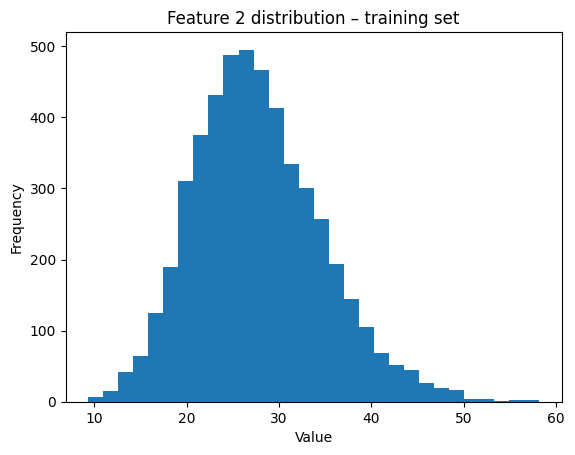

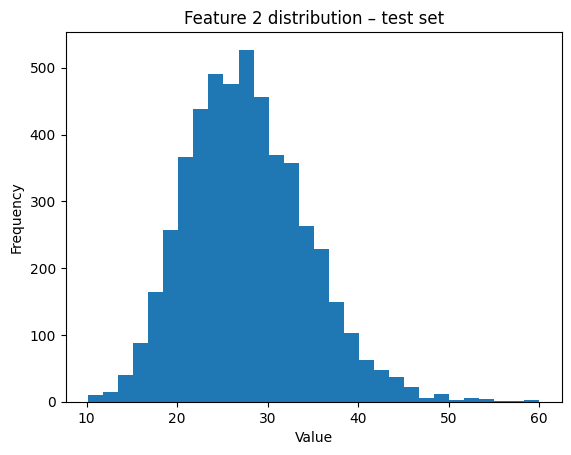

In [37]:
import matplotlib.pyplot as plt

feat = 2

train_stats = {
    'mean': x_train[feat].mean(),
    'median': x_train[feat].median(),
    'std': x_train[feat].std(),
    'min': x_train[feat].min(),
    'max': x_train[feat].max()}

test_stats = {
    'mean': x_test[feat].mean(),
    'median': x_test[feat].median(),
    'std': x_test[feat].std(),
    'min': x_test[feat].min(),
    'max': x_test[feat].max()}


print("Feature 2 – training set statistics:")
print(train_stats)
print("\nFeature 2 – test set statistics:")
print(test_stats)

plt.figure()
plt.hist(x_train[feat], bins=30)
plt.title('Feature 2 distribution – training set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

plt.figure()
plt.hist(x_test[feat], bins=30)
plt.title('Feature 2 distribution – test set')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


What we can observe is that mean and median values are nearly identical between the two sets. Such trend means good consistency and no distribution shift for this feature. Moreover, we have no evidence of train-test drift for this feature. This is crucial because we want features that behave similarly in both training and test data.

The overlap between these two sets shows the above conclusion in even a better way, as well as the plots below (barplots, violin plots):

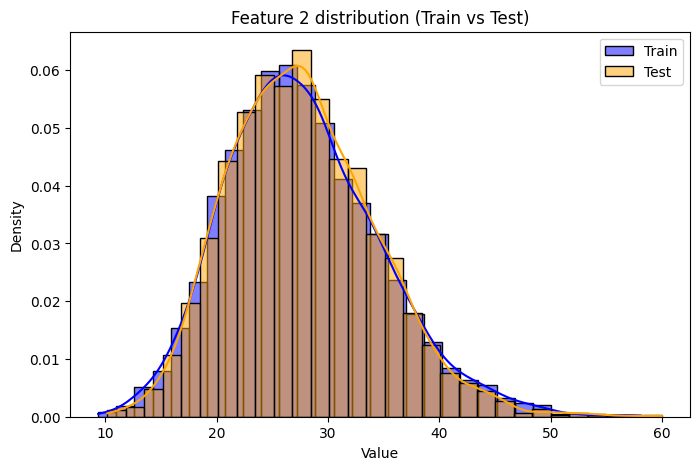

In [38]:
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(x_train[feat], bins=30, color='blue', stat='density', label='Train', kde=True, alpha=0.5)
sns.histplot(x_test[feat], bins=30, color='orange', stat='density', label='Test', kde=True, alpha=0.5)
plt.legend()
plt.title(f'Feature {feat} distribution (Train vs Test)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

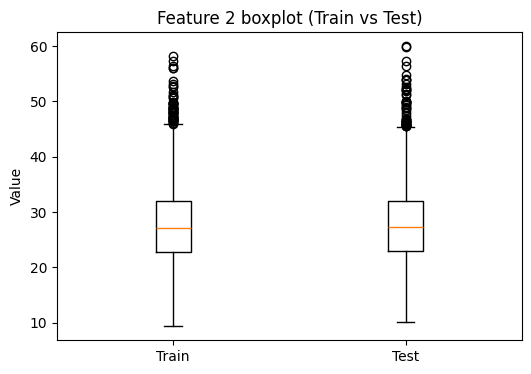

In [48]:
plt.figure(figsize=(6,4))
plt.boxplot([x_train[feat], x_test[feat]], tick_labels=['Train', 'Test'])
plt.title(f'Feature {feat} boxplot (Train vs Test)')
plt.ylabel('Value')
plt.show()

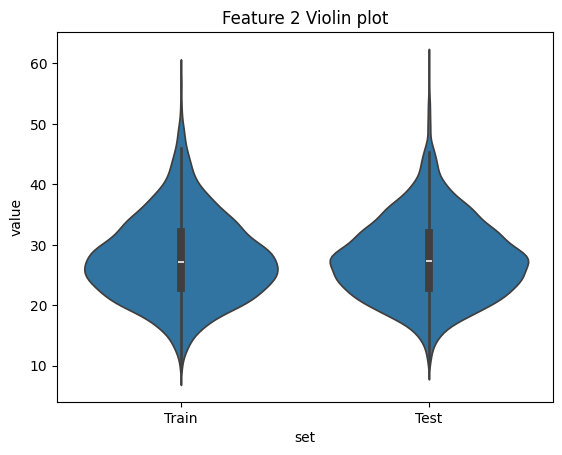

In [40]:
import pandas as pd

tmp = pd.DataFrame({
    'value': np.concatenate([x_train[feat], x_test[feat]]),
    'set': ['Train']*len(x_train) + ['Test']*len(x_test)})

sns.violinplot(x='set', y='value', data=tmp)
plt.title(f'Feature {feat} Violin plot')
plt.show()

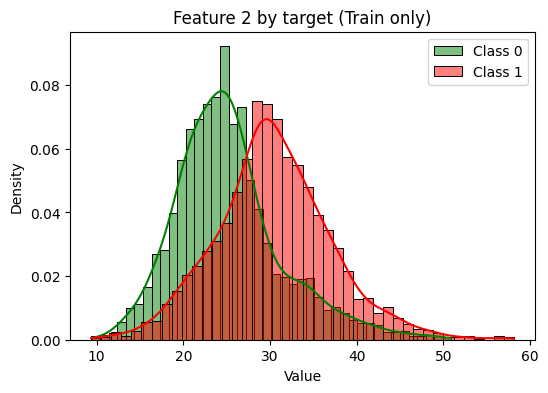

In [47]:
plt.figure(figsize=(6,4))
sns.histplot(x_train[feat][y_train == 0], color='green', label='Class 0', stat='density', kde=True, alpha=0.5)
sns.histplot(x_train[feat][y_train == 1], color='red', label='Class 1', stat='density', kde=True, alpha=0.5)
plt.legend()
plt.title(f'Feature {feat} by target (Train only)')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()


The plot of feature above 2 by target shows a clear difference in distributions between the two classes. Households with higher values of feature 2 are much more likely to exceed the usage threshold (class 1), while lower values are associated with class 0. This strong separation indicates that Feature 2 is a highly informative predictor for the classification task.

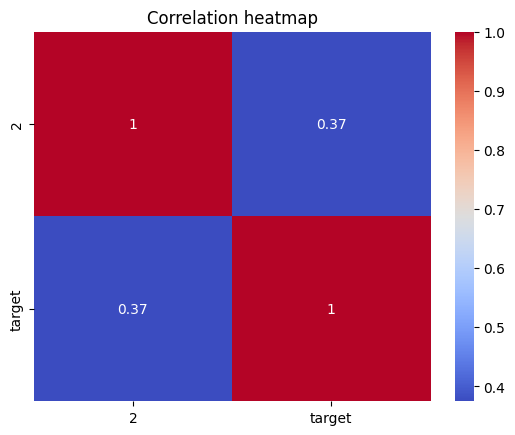

In [44]:
selected_feats = [2]  # top features
corr_matrix = x_train[selected_feats].assign(target=y_train).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation heatmap')
plt.show()